<a href="https://colab.research.google.com/github/daniel3400-ui/NLPCoursework/blob/main/NLPCoursework_Daniel_Davis_6705228_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt

#Loading dataset
dataset = load_dataset("surrey-nlp/PLOD-CW")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 10.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
# Displays the first 5 rows of the dataset
train_dataset = dataset['train']
first_five_rows = train_dataset.select(range(5))

import pandas as pd
df = pd.DataFrame(first_five_rows)
print(df)

                                              tokens  \
0  [For, this, purpose, the, Gothenburg, Young, P...   
1  [The, following, physiological, traits, were, ...   
2  [Minor, H, antigen, alloimmune, responses, rea...   
3                 [EPI, =, Echo, planar, imaging, .]   
4  [Furthermore, ,, eNOS, -, derived, NO, S, -, n...   

                                            pos_tags  \
0  [ADP, DET, NOUN, DET, PROPN, PROPN, PROPN, PRO...   
1  [DET, ADJ, ADJ, NOUN, AUX, VERB, PUNCT, ADJ, N...   
2  [ADJ, PROPN, NOUN, ADJ, NOUN, ADV, VERB, ADP, ...   
3            [PROPN, PUNCT, NOUN, NOUN, NOUN, PUNCT]   
4  [ADV, PUNCT, PROPN, PUNCT, VERB, PROPN, NOUN, ...   

                                            ner_tags  
0  [B-O, B-O, B-O, B-O, B-LF, I-LF, I-LF, I-LF, I...  
1  [B-O, B-O, B-O, B-O, B-O, B-O, B-O, B-LF, I-LF...  
2  [B-O, B-AC, B-O, B-O, B-O, B-O, B-O, B-O, B-O,...  
3                 [B-AC, B-O, B-LF, I-LF, I-LF, B-O]  
4  [B-O, B-O, B-AC, B-O, B-O, B-AC, B-O, B-O, B-O..

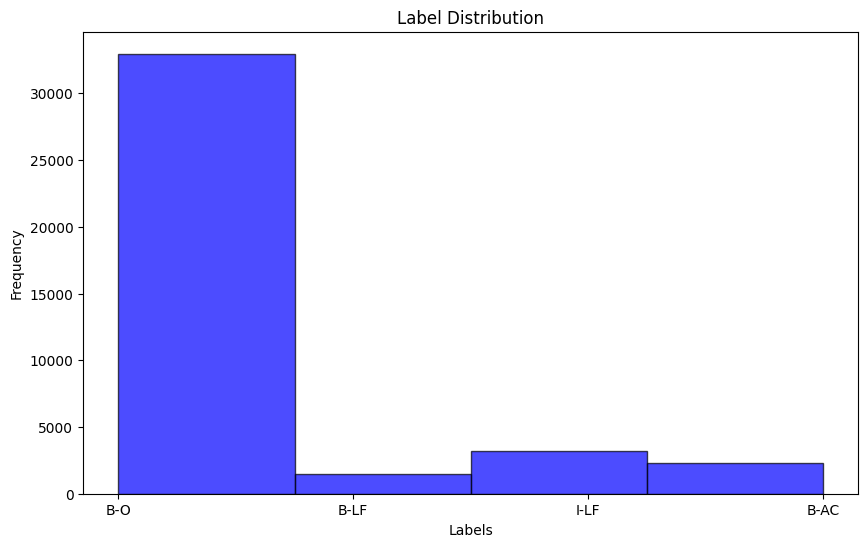

In [ ]:
#Graph that displays the label distribution
def plot_label_distribution(dataset_split):
    labels = [example['ner_tags'] for example in dataset_split]
    labels_flat = [label for sublist in labels for label in sublist]

    plt.figure(figsize=(10, 6))
    plt.hist(labels_flat, bins=len(set(labels_flat)), alpha=0.7, color='blue', edgecolor='black')
    plt.title('Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('Frequency')
    plt.xticks(range(len(set(labels_flat))))
    plt.show()


plot_label_distribution(dataset['train'])

Experiment 2.1 Support Vector Machines!!
Accuracy: 0.9081632653061225, Precision: 0.7814379992730764, Recall: 0.7482976789506046, F1 Score: 0.7623348879422287


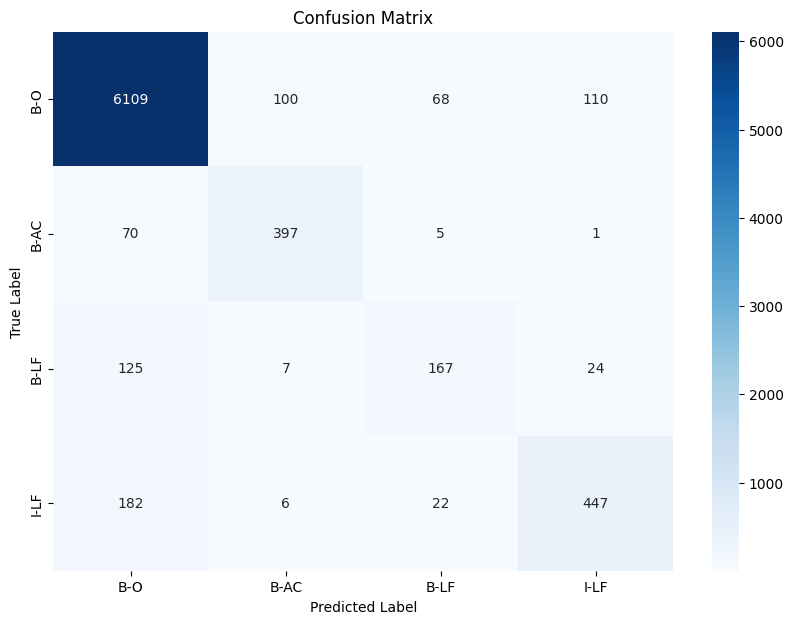

In [ ]:
#Experiment 2.1 Support Vector Machines
import torch
from transformers import BertModel, AutoTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loading theee datasettt :)
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# Labels that get mapped to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

#extracts the labels from the dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

#intiailsie bert and the model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
model = BertModel.from_pretrained('bert-base-uncased').to(device)


def tokenize_and_align_labels(texts, labels):
    tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_masks = tokenized_inputs['attention_mask'].to(device)

    all_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    #makes sure it matches the input shape so no error occurs!!
    padded_labels = [np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in all_labels]
    label_tensors = torch.tensor(np.array(padded_labels)).to(device)
    return input_ids, attention_masks, label_tensors

input_ids, attention_masks, label_tensors = tokenize_and_align_labels(texts, labels)

def extract_embeddings(input_ids, attention_masks):
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state
    return embeddings

embeddings = extract_embeddings(input_ids, attention_masks)

def flatten_embeddings_and_labels(embeddings, label_tensors):
    embeddings = embeddings.view(-1, embeddings.size(-1))
    labels = label_tensors.view(-1)
    mask = labels != -100
    embeddings = embeddings[mask]
    labels = labels[mask]
    return embeddings, labels

embeddings, labels = flatten_embeddings_and_labels(embeddings, label_tensors)

# splits data
train_embeddings, test_embeddings, train_labels, test_labels = train_test_split(embeddings.cpu().numpy(), labels.cpu().numpy(), test_size=0.2, random_state=42)

#training
svm_classifier = SGDClassifier(loss='hinge')
svm_classifier.fit(train_embeddings, train_labels)

#and finally evaluation!
predictions = svm_classifier.predict(test_embeddings)
precision, recall, f1, _ = precision_recall_fscore_support(test_labels, predictions, average='macro')
accuracy = accuracy_score(test_labels, predictions)
print("Experiment 2.1 Support Vector Machines")
print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# displays a confusion matrix
cm = confusion_matrix(test_labels, predictions, labels=[0, 1, 2, 3])

label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Epoch 1/10, Loss: 0.3150628445049127
Epoch 2/10, Loss: 0.18680749633521945
Epoch 3/10, Loss: 0.14490235170901375
Epoch 4/10, Loss: 0.11670696664670552
Epoch 5/10, Loss: 0.08510850044398534
Epoch 6/10, Loss: 0.0690288052600981
Epoch 7/10, Loss: 0.04786803481854602
Epoch 8/10, Loss: 0.034134851833288044
Epoch 9/10, Loss: 0.024085753394670232
Epoch 10/10, Loss: 0.020384750508431655
Experiment 2.2 RNN
Accuracy: 0.9231258750159094, Precision: 0.7865083395795741, Recall: 0.8519588358859694, F1 Score: 0.8163633403585152


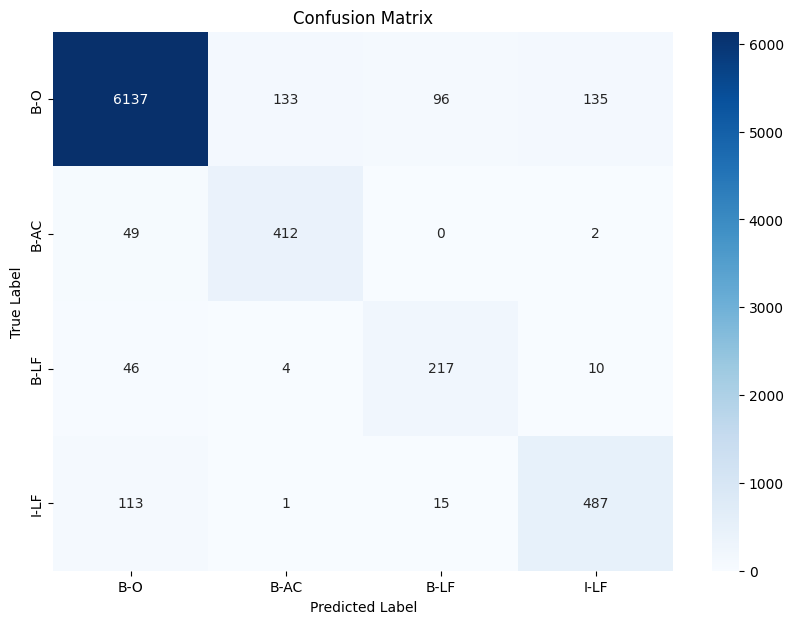

In [ ]:
#Experiment 2.2 RNNs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, AutoTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loading theee datasettt :)
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# Labels that get mapped to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

#extracts the labels from the dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

#intiailsie bert and the model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def tokenize_and_align_labels(texts, labels):
    tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_masks = tokenized_inputs['attention_mask'].to(device)

    all_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    padded_labels = [np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in all_labels]
    label_tensors = torch.tensor(np.array(padded_labels)).to(device)
    return input_ids, attention_masks, label_tensors

input_ids, attention_masks, label_tensors = tokenize_and_align_labels(texts, labels)

def extract_embeddings(input_ids, attention_masks):
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state
    return embeddings

embeddings = extract_embeddings(input_ids, attention_masks)

#the rnn model
class RNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout_prob=0.5):
        super(RNNClassifier, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_prob if num_layers > 1 else 0, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        rnn_out, _ = self.rnn(x)
        out = self.fc(rnn_out)
        return out

#intialise paramters
input_dim = embeddings.shape[-1]
hidden_dim = 256
num_layers = 2
dropout_prob = 0.5
output_dim = 4
rnn_model = RNNClassifier(input_dim, hidden_dim, output_dim, num_layers, dropout_prob).to(device)

#preperation for training, testinggg
batch_size = 8
train_data, test_data = train_test_split(TensorDataset(embeddings, label_tensors), test_size=0.2, random_state=42) # split dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  #ignroes values with -100
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))  # Flatten outputs and labels
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# training
train_model(rnn_model, train_loader)

#evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            #ignore -100 vals
            mask = labels != -100
            filtered_outputs = outputs[mask]
            filtered_labels = labels[mask]

            _, predicted = torch.max(filtered_outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(filtered_labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    #display metrics and confusion matrix
    print("Experiment 2.2 RNN")
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')
    cm = confusion_matrix(true_labels, predictions)
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

evaluate_model(rnn_model, test_loader)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Epoch 1/10, Loss: 0.36665961242936274
Epoch 2/10, Loss: 0.2515010115587049
Epoch 3/10, Loss: 0.22461725543770525
Epoch 4/10, Loss: 0.21021359879523516
Epoch 5/10, Loss: 0.19178504469218077
Epoch 6/10, Loss: 0.18069408644266702
Epoch 7/10, Loss: 0.16966732553447839
Epoch 8/10, Loss: 0.16032579658484017
Epoch 9/10, Loss: 0.15207099231580892
Epoch 10/10, Loss: 0.1471178734123155
Experiment 2.3 and Experiment 3.1 FNN with Pretrained model
Accuracy: 0.9126893216240295, Precision: 0.8014658717851737, Recall: 0.7269622543563768, F1 Score: 0.7599848071620998


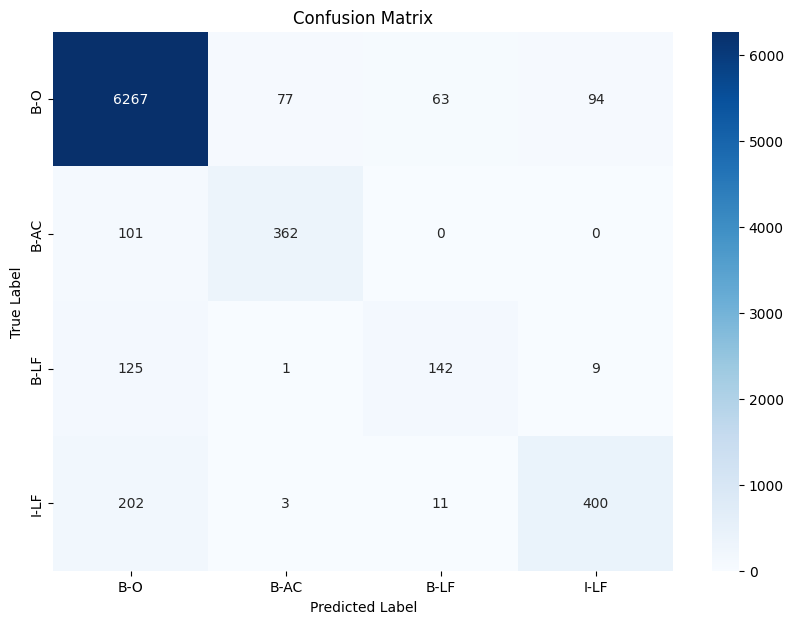

Experiment 2.3 and Experiment 3.1 FNN with Pretrained model
Accuracy: 0.9126893216240295, Precision: 0.8014658717851737, Recall: 0.7269622543563768, F1 Score: 0.7599848071620998


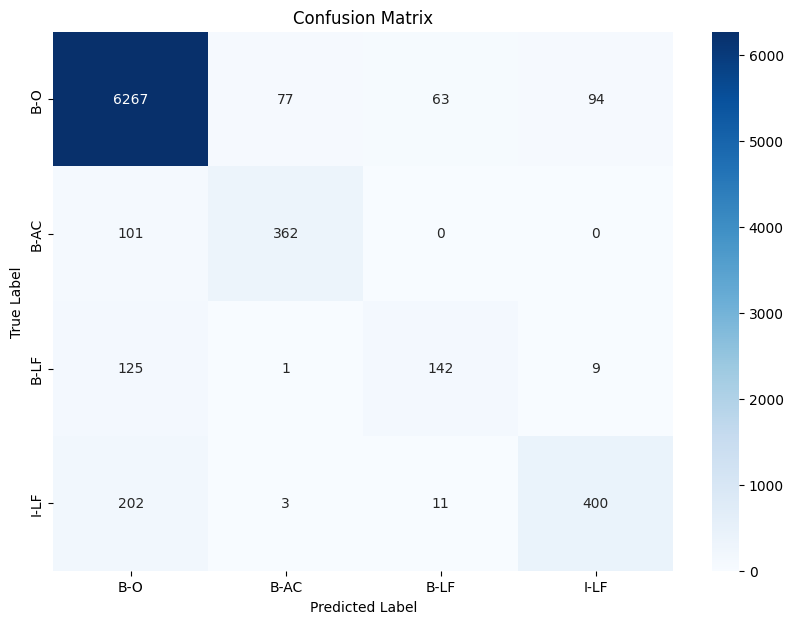

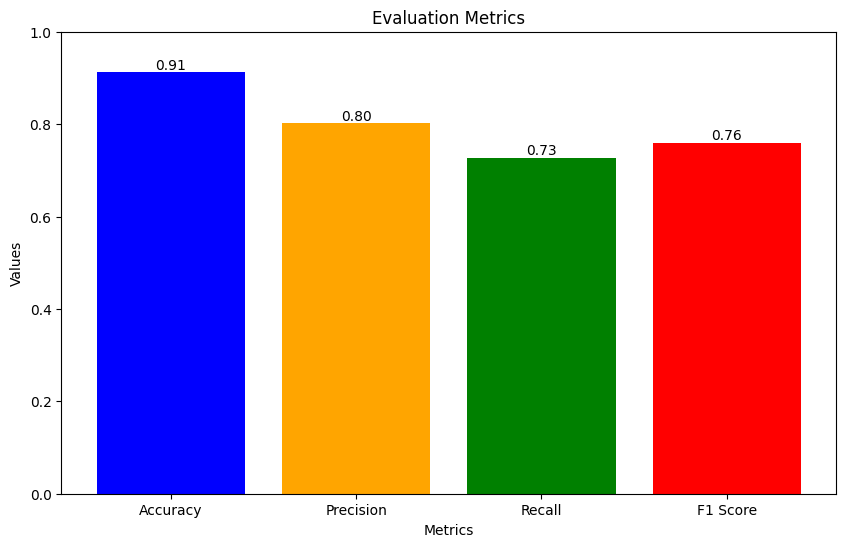

In [ ]:
#Experiment 3.1 and Experiment 2.3 FNN with Pre trained model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertModel, AutoTokenizer
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#loading theee datasettt :)
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# Labels that get mapped to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

# Helper function to convert NER tags to corresponding numeric labels
def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

#extracts the labels from the dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

#intiailsie bert and the model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

def tokenize_and_align_labels(texts, labels):
    tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)
    input_ids = tokenized_inputs['input_ids'].to(device)
    attention_masks = tokenized_inputs['attention_mask'].to(device)

    all_labels = []
    for i, label in enumerate(labels):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None or word_idx == previous_word_idx:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_idx])
            previous_word_idx = word_idx
        all_labels.append(label_ids)

    padded_labels = [np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in all_labels]
    label_tensors = torch.tensor(np.array(padded_labels)).to(device)
    return input_ids, attention_masks, label_tensors

input_ids, attention_masks, label_tensors = tokenize_and_align_labels(texts, labels)


def extract_embeddings(input_ids, attention_masks):
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_masks)
        embeddings = outputs.last_hidden_state
    return embeddings

embeddings = extract_embeddings(input_ids, attention_masks)

class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(FFNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#initialise paramaters
input_dim = embeddings.shape[-1]
hidden_dim = 256
dropout_prob = 0.5
output_dim = 4

ffnn_model = FFNNClassifier(input_dim, hidden_dim, output_dim, dropout_prob).to(device)


batch_size = 8
train_data, test_data = train_test_split(TensorDataset(embeddings, label_tensors), test_size=0.2, random_state=42) #split dataset
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

def train_model(model, train_loader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # Ignore padding
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))  # Flatten outputs and labels
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

# train model
train_model(ffnn_model, train_loader)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#evaluate
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            #ignore -100 values
            mask = labels != -100
            filtered_outputs = outputs[mask]
            filtered_labels = labels[mask]

            _, predicted = torch.max(filtered_outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(filtered_labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    #Print out metrics and confusion matrix
    print("Experiment 2.3 and Experiment 3.1 FNN with Pretrained model")
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    cm = confusion_matrix(true_labels, predictions)
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Evaluate the FFNN model
evaluate_model(ffnn_model, test_loader)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the evaluate_model function
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            # Ignore -100 values
            mask = labels != -100
            filtered_outputs = outputs[mask]
            filtered_labels = labels[mask]

            _, predicted = torch.max(filtered_outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(filtered_labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    # Print out metrics
    print("Experiment 2.3 and Experiment 3.1 FNN with Pretrained model")
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot accuracy, precision, recall, and F1 score
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    values = [accuracy, precision, recall, f1]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

    plt.ylim(0, 1)
    plt.title('Evaluation Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Values')
    plt.show()

# Evaluate the FFNN model
evaluate_model(ffnn_model, test_loader)


NameError: name 'ffnn_model' is not defined

Epoch 1/10, Loss: 0.7787765639799612
Epoch 2/10, Loss: 0.5004191061964741
Epoch 3/10, Loss: 0.46408105200087585
Epoch 4/10, Loss: 0.45636520589943286
Epoch 5/10, Loss: 0.4453758747765311
Epoch 6/10, Loss: 0.43860974852685575
Epoch 7/10, Loss: 0.4329416822228167
Epoch 8/10, Loss: 0.4176731686349268
Epoch 9/10, Loss: 0.41407115950628565
Epoch 10/10, Loss: 0.4118498796942057
Experiment 3.2 FNN with Word2Vec
Accuracy: 0.8519376066292956, Precision: 0.6284479655694497, Recall: 0.4539881660168302, F1 Score: 0.495887131894859


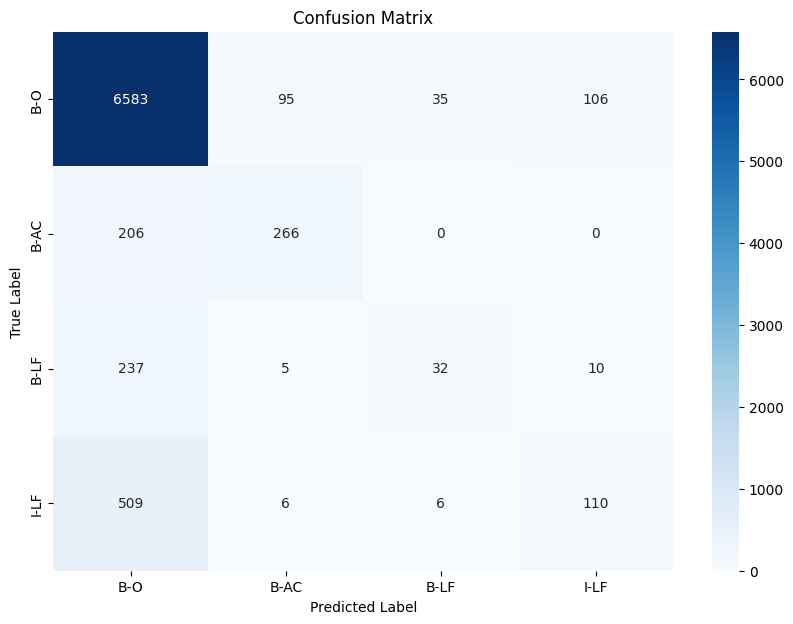

In [ ]:
#Experiment 3.2 Word2Vec
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from datasets import load_dataset
import numpy as np
import gensim.downloader as api
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

#loading dataset
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# map label to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

# Extract tokens from dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load word2vec model
word2vec = api.load('word2vec-google-news-300')

# converts the token to word2vec embeddings
def tokens_to_word2vec_embeddings(tokens_list, model):
    embeddings = []
    for tokens in tokens_list:
        token_embeddings = [torch.tensor(model[token]) if token in model.key_to_index else torch.zeros(model.vector_size) for token in tokens]
        embeddings.append(torch.stack(token_embeddings))
    return embeddings

embeddings = tokens_to_word2vec_embeddings(texts, word2vec)

def pad_tensor_sequences(sequences, padding_value=0):
    max_len = max([s.size(0) for s in sequences])
    padded_sequences = torch.stack([torch.cat([s, torch.full((max_len - s.size(0), s.size(1)), padding_value)]) if s.size(0) < max_len else s for s in sequences])
    return padded_sequences

embeddings_padded = pad_tensor_sequences(embeddings)

max_len_labels = max([len(label) for label in labels])
padded_labels = [label + [-100] * (max_len_labels - len(label)) for label in labels]
label_tensors = torch.tensor(padded_labels, dtype=torch.long)

embeddings_tensor = embeddings_padded.to(device)
label_tensors = label_tensors.to(device)


train_data, test_data = train_test_split(TensorDataset(embeddings_tensor, label_tensors), test_size=0.2, random_state=42)
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# define FNN model
class FFNNClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob=0.5):
        super(FFNNClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# intialise parameters
input_dim = 300
hidden_dim = 256
output_dim = len(label_mapping)

ffnn_model = FFNNClassifier(input_dim, hidden_dim, output_dim, dropout_prob=0.5).to(device)

# training
def train_model(model, train_loader, num_epochs=10, learning_rate=1e-3):
    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings.view(-1, embeddings.shape[-1]))
            outputs = outputs.view(embeddings.size(0), embeddings.size(1), -1)  #
            loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_loader)}')

#evaluation
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings)
            outputs = outputs.view(-1, outputs.shape[-1])
            labels = labels.view(-1)

            # ignore values with -100
            mask = labels != -100
            filtered_outputs = outputs[mask]
            filtered_labels = labels[mask]

            _, predicted = torch.max(filtered_outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(filtered_labels.cpu().numpy())

    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)

    #print out metrics and confusion matrix
    print("Experiment 3.2 FNN with Word2Vec")
    print(f'Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

    cm = confusion_matrix(true_labels, predictions)
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# train and evaluate it!
train_model(ffnn_model, train_loader)
evaluate_model(ffnn_model, test_loader)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Loss 0.32943231089318054
Epoch 2: Loss 0.14857707564976622
Epoch 3: Loss 0.08771691631842801
Epoch 4: Loss 0.053276436274593816
Epoch 5: Loss 0.034552263125697986
Epoch 6: Loss 0.021779449631836503
Experiment 1.3 Linear Decay Learning Rate


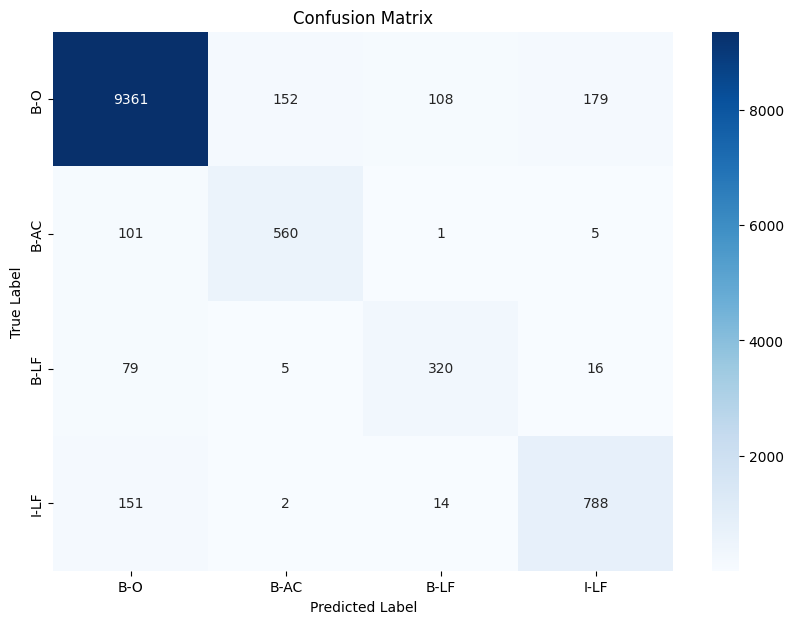

Precision: 0.8161565323207196, Recall: 0.8454549858712058, F1: 0.8303233311805829, Accuracy: 0.9313460564093903


In [ ]:
#Experiment 1.3 Linear Decay
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForTokenClassification, AdamW
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # Seaborn for nicer confusion matrix visualization
from collections import Counter


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# label map to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

# extrat token from dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

# intialises tokeniser
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)

#aligns the labels with the tokenised inputs to prepare for token classification yay!!
input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']
label_ids = []
for i, label in enumerate(labels):
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx = None
    label_ids.append([])
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
            label_ids[-1].append(-100)
        else:
            label_ids[-1].append(label[word_idx])
        previous_word_idx = word_idx

label_tensors = torch.tensor([np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in label_ids])

#split dataset
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, label_tensors, attention_masks, test_size=0.3, random_state=42)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#initalise model
model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping)).to(device)

#sets default learning rate
optimizer = AdamW(model.parameters(), lr=5e-5)

#computes the linear decay
def adjust_learning_rate(optimizer, epoch, total_epochs, initial_lr):
    new_lr = initial_lr * (1 - epoch / total_epochs)
    for param_group in optimizer.param_groups:
        param_group['lr'] = new_lr

#trains model with linear decay
def train_model(model, train_loader, optimizer, device, num_epochs=6, initial_lr=5e-5):
    model.train()
    total_epochs = num_epochs
    for epoch in range(num_epochs):
        adjust_learning_rate(optimizer, epoch, total_epochs, initial_lr)

        total_loss = 0
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader)}")

#evaluates model
def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(batch[2].detach().cpu().numpy())


    processed_predictions = []
    processed_true_labels = []
    for pred, label in zip(predictions, true_labels):
        temp_pred = []
        temp_label = []
        for p, l in zip(pred, label):
            if l != -100:  #ignroes any value that is -100!
                temp_pred.append(p)
                temp_label.append(l)
        processed_predictions.append(temp_pred)
        processed_true_labels.append(temp_label)
    flat_predictions = [p for sublist in processed_predictions for p in sublist]
    flat_true_labels = [l for sublist in processed_true_labels for l in sublist]

    #display confusion matrix and accuracy metrics
    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=[0, 1, 2, 3])

    print("Experiment 1.3 Linear Decay Learning Rate")
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")


train_model(model, train_loader, optimizer, device)
evaluate_model(model, test_loader, device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1072 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/126 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/153 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<ipython-input-3-db83ab630354>:50: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:274.)
  label_tensors = torch.tensor([np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in label_ids])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Loss 0.3334673377586172
Epoch 2: Loss 0.1499527960302348
Epoch 3: Loss 0.09506164114684501
Epoch 4: Loss 0.055240310837534515
Epoch 5: Loss 0.033351818976448254
Epoch 6: Loss 0.0281714842421934
Experiment 3.1/4.1 Constant Learning Rate/Cross Entropy Loss


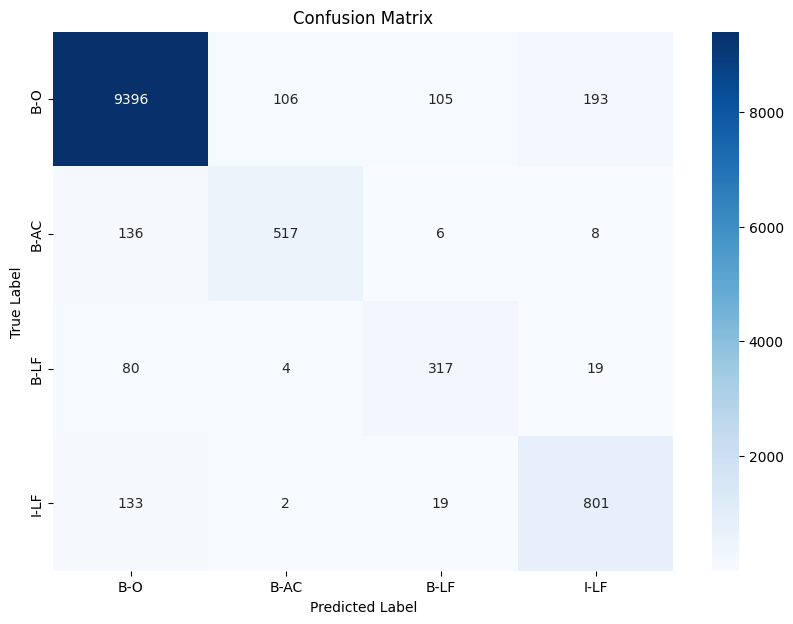

Precision: 0.8199558960274447, Recall: 0.8318483285603698, F1: 0.8253247456295079, Accuracy: 0.9315149467995271


In [ ]:
#Experiment 1.3 Constant Learning Rate
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForTokenClassification, AdamW
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# loading dataset
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# map label to numbers
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}


def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

#extract token from dataset
texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)


#aligns the labels with the tokenised inputs to prepare for token classification yay!!
input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']
label_ids = []
for i, label in enumerate(labels):
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx = None
    label_ids.append([])
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
            label_ids[-1].append(-100)
        else:
            label_ids[-1].append(label[word_idx])
        previous_word_idx = word_idx

label_tensors = torch.tensor([np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in label_ids])

# splt dataset
train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, label_tensors, attention_masks, test_size=0.3, random_state=42)


train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping)).to(device)


optimizer = AdamW(model.parameters(), lr=5e-5)  # Constant learning rate


def train_model(model, train_loader, optimizer, device, num_epochs=6):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in train_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: Loss {total_loss / len(train_loader)}")

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(batch[2].detach().cpu().numpy())

    processed_predictions = []
    processed_true_labels = []
    for pred, label in zip(predictions, true_labels):
        temp_pred = []
        temp_label = []
        for p, l in zip(pred, label):
            if l != -100:
                temp_pred.append(p)
                temp_label.append(l)
        processed_predictions.append(temp_pred)
        processed_true_labels.append(temp_label)


    flat_predictions = [p for sublist in processed_predictions for p in sublist]
    flat_true_labels = [l for sublist in processed_true_labels for l in sublist]

    print("Experiment 3.1/4.1 Constant Learning Rate/Cross Entropy Loss")
    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=[0, 1, 2, 3])
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")

train_model(model, train_loader, optimizer, device)
evaluate_model(model, test_loader, device)


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.2 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Loss 0.3273416509495137
Epoch 2: Loss 0.14588542995934792
Epoch 3: Loss 0.09229033350191534
Epoch 4: Loss 0.0550115000000818
Epoch 5: Loss 0.03623383556631334
Epoch 6: Loss 0.02734553738140521


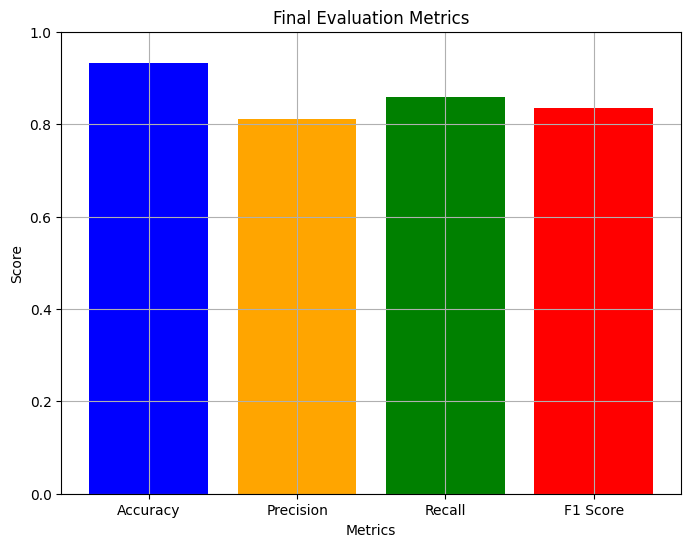

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForTokenClassification, AdamW, get_cosine_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset
dataset = load_dataset("surrey-nlp/PLOD-CW", split='train')

# Label map to number
label_mapping = {'B-O': 0, 'B-AC': 1, 'B-LF': 2, 'I-LF': 3}

def ner_tags_to_ids(ner_tags, label_map):
    return [label_map[tag] for tag in ner_tags]

texts = [entry['tokens'] for entry in dataset]
labels = [ner_tags_to_ids(entry['ner_tags'], label_mapping) for entry in dataset]

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', use_fast=True)

tokenized_inputs = tokenizer(texts, is_split_into_words=True, return_tensors="pt", padding=True, truncation=True, max_length=128)
# Aligns the labels with the tokenised inputs to prepare for token classification yay!!
input_ids = tokenized_inputs['input_ids']
attention_masks = tokenized_inputs['attention_mask']
label_ids = []
for i, label in enumerate(labels):
    word_ids = tokenized_inputs.word_ids(batch_index=i)
    previous_word_idx = None
    label_ids.append([])
    for word_idx in word_ids:
        if word_idx is None or word_idx == previous_word_idx:
            label_ids[-1].append(-100)
        else:
            label_ids[-1].append(label[word_idx])
        previous_word_idx = word_idx

label_tensors = torch.tensor([np.pad(label, (0, input_ids.shape[1] - len(label)), mode='constant', constant_values=-100) for label in label_ids])

train_inputs, test_inputs, train_labels, test_labels, train_masks, test_masks = train_test_split(input_ids, label_tensors, attention_masks, test_size=0.3, random_state=42)

train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(label_mapping)).to(device)

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 6

total_steps = len(train_loader) * num_epochs

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Train model and collect metrics
def train_model(model, train_loader, test_loader, optimizer, scheduler, device, num_epochs=6):
    train_loss_values = []
    accuracy_values = []
    precision_values = []
    recall_values = []
    f1_values = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for step, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_loss_values.append(avg_train_loss)
        print(f"Epoch {epoch+1}: Loss {avg_train_loss}")

        # Evaluate the model on the test set after each epoch
        metrics = evaluate_model(model, test_loader, device)
        accuracy_values.append(metrics['accuracy'])
        precision_values.append(metrics['precision'])
        recall_values.append(metrics['recall'])
        f1_values.append(metrics['f1'])

    return train_loss_values, accuracy_values, precision_values, recall_values, f1_values

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(batch[2].detach().cpu().numpy())

    processed_predictions = []
    processed_true_labels = []
    for pred, label in zip(predictions, true_labels):
        temp_pred = []
        temp_label = []
        for p, l in zip(pred, label):
            if l != -100:
                temp_pred.append(p)
                temp_label.append(l)
        processed_predictions.append(temp_pred)
        processed_true_labels.append(temp_label)

    flat_predictions = [p for sublist in processed_predictions for p in sublist]
    flat_true_labels = [l for sublist in processed_true_labels for l in sublist]

    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy
    }

train_loss_values, accuracy_values, precision_values, recall_values, f1_values = train_model(model, train_loader, test_loader, optimizer, scheduler, device, num_epochs)

# Plot the final metrics
final_metrics = {
    'Accuracy': accuracy_values[-1],
    'Precision': precision_values[-1],
    'Recall': recall_values[-1],
    'F1 Score': f1_values[-1]
}

plt.figure(figsize=(8, 6))
plt.bar(final_metrics.keys(), final_metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Final Evaluation Metrics')
plt.ylim(0, 1)  # Assuming the metrics are between 0 and 1
plt.grid(True)
plt.show()


In [ ]:
# Modified functions to track and plot precision, recall, F1 score, and accuracy
def train_model(model, train_loader, optimizer, scheduler, device, num_epochs=6):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for step, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss {avg_loss}")
    return train_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(batch[2].detach().cpu().numpy())

    processed_predictions = []
    processed_true_labels = []
    for pred, label in zip(predictions, true_labels):
        temp_pred = []
        temp_label = []
        for p, l in zip(pred, label):
            if l != -100:
                temp_pred.append(p)
                temp_label.append(l)
        processed_predictions.append(temp_pred)
        processed_true_labels.append(temp_label)

    flat_predictions = [p for sublist in processed_predictions for p in sublist]
    flat_true_labels = [l for sublist in processed_true_labels for l in sublist]

    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=[0, 1, 2, 3])
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")

    return precision, recall, f1, accuracy

# Main function to train and evaluate the model, and plot the metrics
def main():
    num_epochs = 6
    train_losses = train_model(model, train_loader, optimizer, scheduler, device, num_epochs)
    precisions, recalls, f1s, accuracies = [], [], [], []

    for epoch in range(num_epochs):
        precision, recall, f1, accuracy = evaluate_model(model, test_loader, device)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(accuracy)

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1s, label='F1 Score')
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1 Score, and Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

main()

NameError: name 'model' is not defined

In [ ]:
#Experiment 1.2 Cosine Decay Learning rate
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertForTokenClassification, AdamW, get_cosine_schedule_with_warmup
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Modified functions to track and plot precision, recall, F1 score, and accuracy
def train_model(model, train_loader, optimizer, scheduler, device, num_epochs=6):
    model.train()
    train_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        for step, batch in enumerate(train_loader):
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1],
                      'labels': batch[2]}
            outputs = model(**inputs)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}: Loss {avg_loss}")
    return train_losses

def evaluate_model(model, test_loader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            batch = tuple(t.to(device) for t in batch)
            inputs = {'input_ids': batch[0],
                      'attention_mask': batch[1]}
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=2)
            predictions.extend(preds.detach().cpu().numpy())
            true_labels.extend(batch[2].detach().cpu().numpy())

    processed_predictions = []
    processed_true_labels = []
    for pred, label in zip(predictions, true_labels):
        temp_pred = []
        temp_label = []
        for p, l in zip(pred, label):
            if l != -100:
                temp_pred.append(p)
                temp_label.append(l)
        processed_predictions.append(temp_pred)
        processed_true_labels.append(temp_label)

    flat_predictions = [p for sublist in processed_predictions for p in sublist]
    flat_true_labels = [l for sublist in processed_true_labels for l in sublist]

    cm = confusion_matrix(flat_true_labels, flat_predictions, labels=[0, 1, 2, 3])
    label_names = ['B-O', 'B-AC', 'B-LF', 'I-LF']
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    precision, recall, f1, _ = precision_recall_fscore_support(flat_true_labels, flat_predictions, average='macro')
    accuracy = accuracy_score(flat_true_labels, flat_predictions)
    print(f"Precision: {precision}, Recall: {recall}, F1: {f1}, Accuracy: {accuracy}")

    return precision, recall, f1, accuracy

# Main function to train and evaluate the model, and plot the metrics
def main():
    num_epochs = 6
    train_losses = train_model(model, train_loader, optimizer, scheduler, device, num_epochs)
    precisions, recalls, f1s, accuracies = [], [], [], []

    for epoch in range(num_epochs):
        precision, recall, f1, accuracy = evaluate_model(model, test_loader, device)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)
        accuracies.append(accuracy)

    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))
    plt.plot(epochs, precisions, label='Precision')
    plt.plot(epochs, recalls, label='Recall')
    plt.plot(epochs, f1s, label='F1 Score')
    plt.plot(epochs, accuracies, label='Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Precision, Recall, F1 Score, and Accuracy over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

main()


NameError: name 'model' is not defined